In [3]:

import matplotlib.pyplot as plt # plotting library
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
data_dir = '/Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100.0%


Extracting /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw/train-images-idx3-ubyte.gz to /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw



100.0%


Extracting /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw



100.0%


Extracting /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw



100.0%

Extracting /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/jyp/Documents/GitHub/FranciscoPark/DS_Portfolio/AutoEncoder/MNIST/raw



In [10]:
#mnist dataset dimension check
print(train_dataset.data.shape)
#check channel number
print(train_dataset.data.shape[0])
#check image size
print(train_dataset.data.shape[1:])
#check number of classes
print(len(train_dataset.classes))


torch.Size([60000, 28, 28])
60000
torch.Size([28, 28])
10


In [17]:
class Encoder(nn.Module):
    def __init__(self, encoded_size,input_dim) -> None:
        super().__init__()
        self.encoded_size=encoded_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),#b,8,14,14
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),#b,16,7,7
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),#b,32,3,3
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten()
        self.encoder_lin= nn.Sequential(
            nn.Linear(32*3*3, 128),
            nn.ReLU(True),
            nn.Linear(128,self.encoded_size)
        )
    def forward(self,x):
        x=self.encoder(x)
        x=self.flatten(x)
        x=self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    def __init__(self, encoded_size,input_dim) -> None:
        super().__init__()
        self.encoded_size=encoded_size
        self.decoder_lin= nn.Sequential(
            nn.Linear(self.encoded_size,128),
            nn.ReLU(True),
            nn.Linear(128,32*3*3),
            nn.ReLU(True),
        )
        self.unflatten=nn.Unflatten(1,(32,3,3))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),#b,16,7,7
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1,output_padding=1),#b,8,14,14
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1,output_padding=1),#b,1,28,28
            nn.ReLU(True),
        )
    def forward(self,x):
        x=self.decoder_lin(x)
        x=self.unflatten(x)
        x=self.decoder(x)
        x=torch.sigmoid(x)
        return x

In [18]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(d,128)
decoder = Decoder(d,128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU(inplace=True)
  )
)

In [29]:

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [30]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [31]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 


 EPOCH 1/50 	 train loss 0.21968974173069 	 val loss 0.21935145556926727


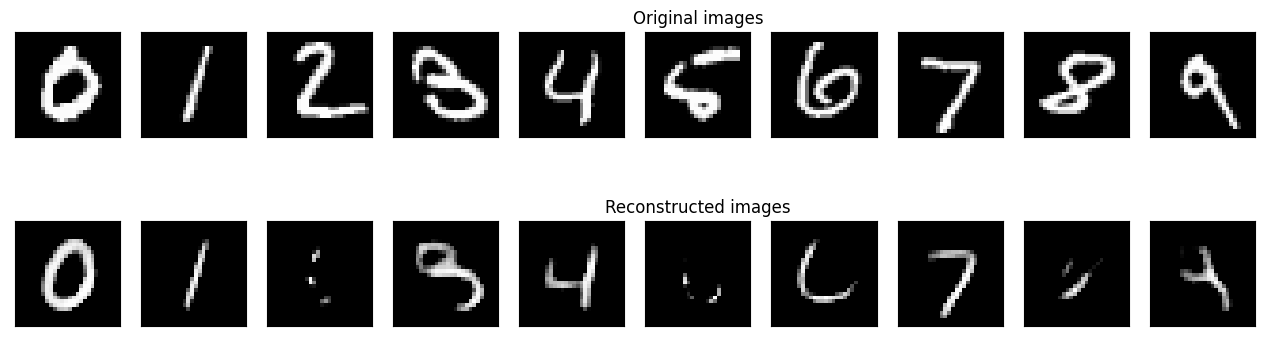


 EPOCH 2/50 	 train loss 0.21966753900051117 	 val loss 0.21933312714099884


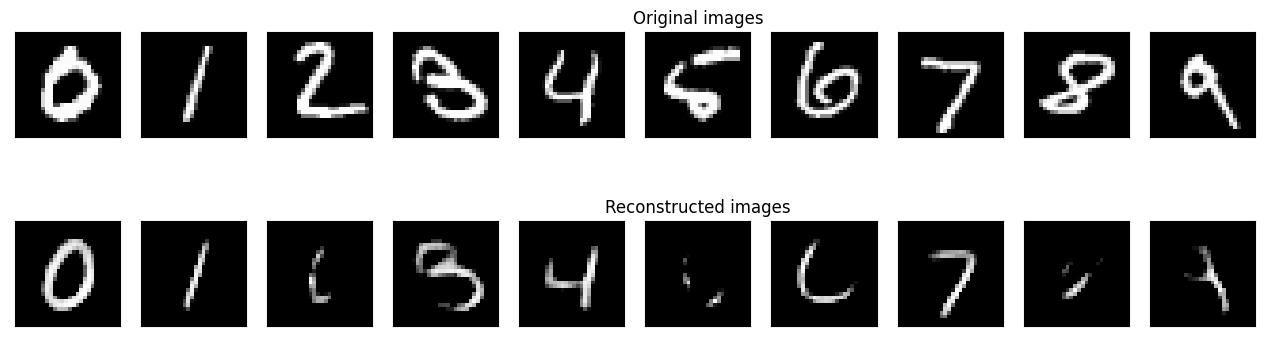


 EPOCH 3/50 	 train loss 0.21965384483337402 	 val loss 0.2193472534418106


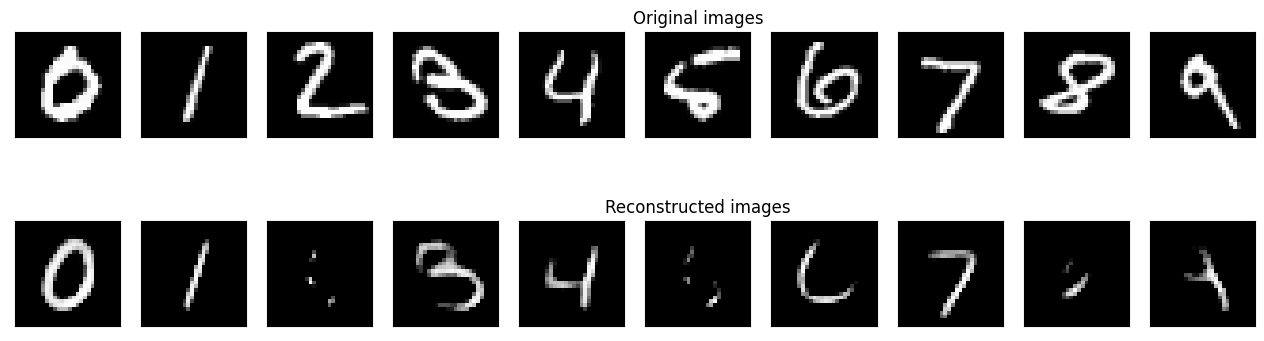


 EPOCH 4/50 	 train loss 0.2196340709924698 	 val loss 0.21925272047519684


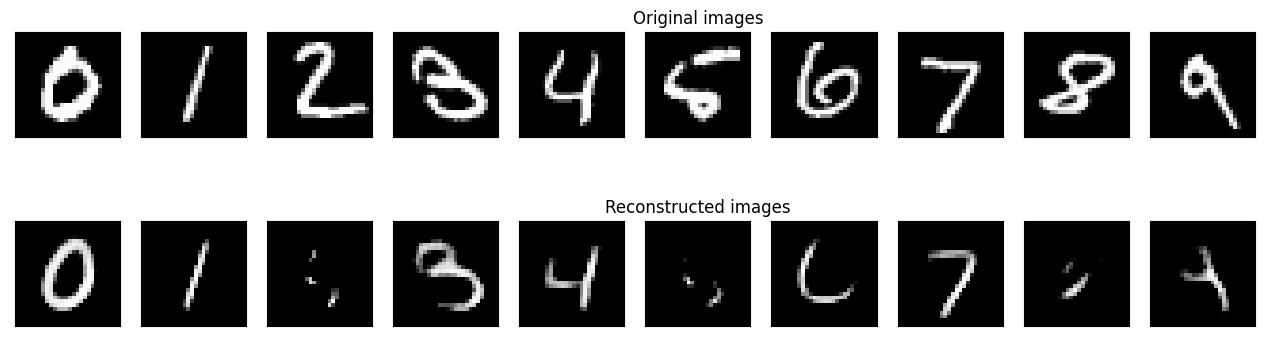


 EPOCH 5/50 	 train loss 0.21962374448776245 	 val loss 0.21922634541988373


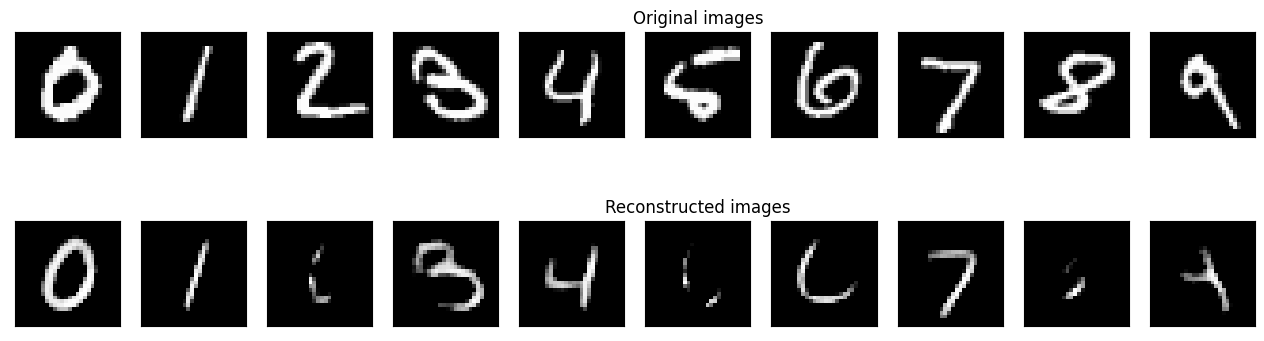


 EPOCH 6/50 	 train loss 0.21960937976837158 	 val loss 0.2192387580871582


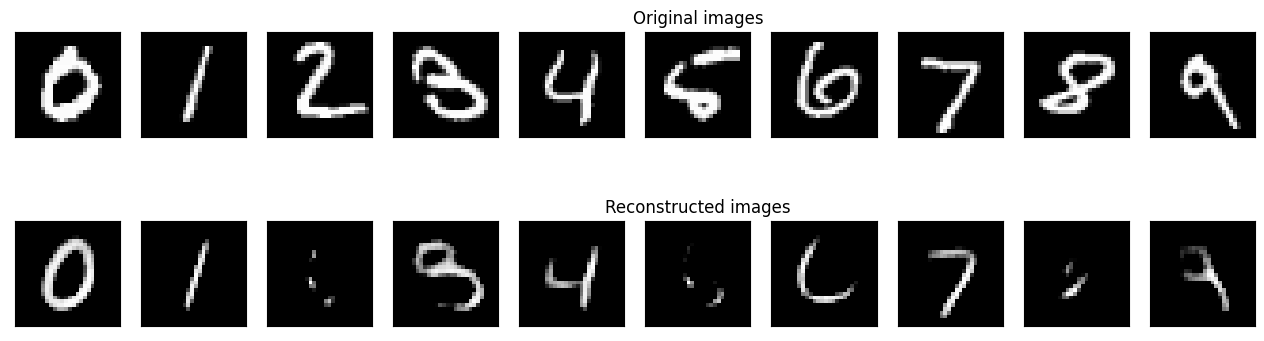


 EPOCH 7/50 	 train loss 0.2196056991815567 	 val loss 0.21922478079795837


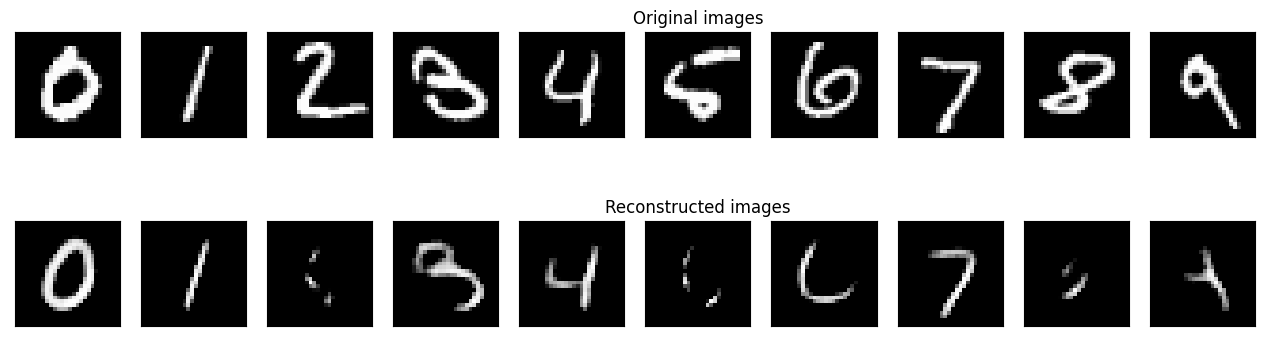


 EPOCH 8/50 	 train loss 0.21959039568901062 	 val loss 0.21925494074821472


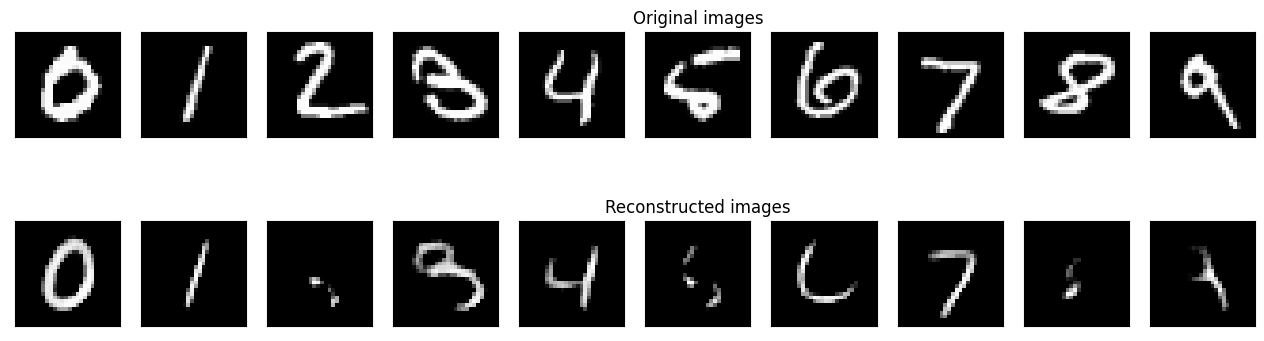


 EPOCH 9/50 	 train loss 0.2195778787136078 	 val loss 0.21928702294826508


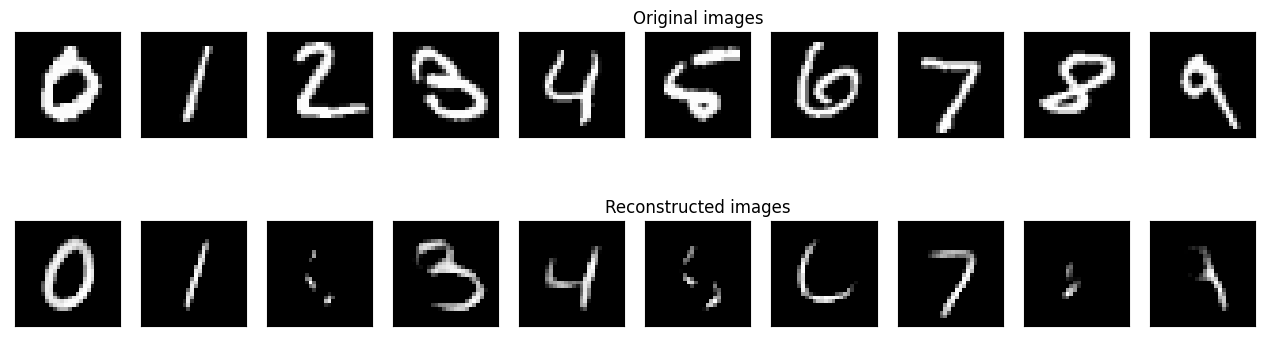


 EPOCH 10/50 	 train loss 0.21956510841846466 	 val loss 0.21922428905963898


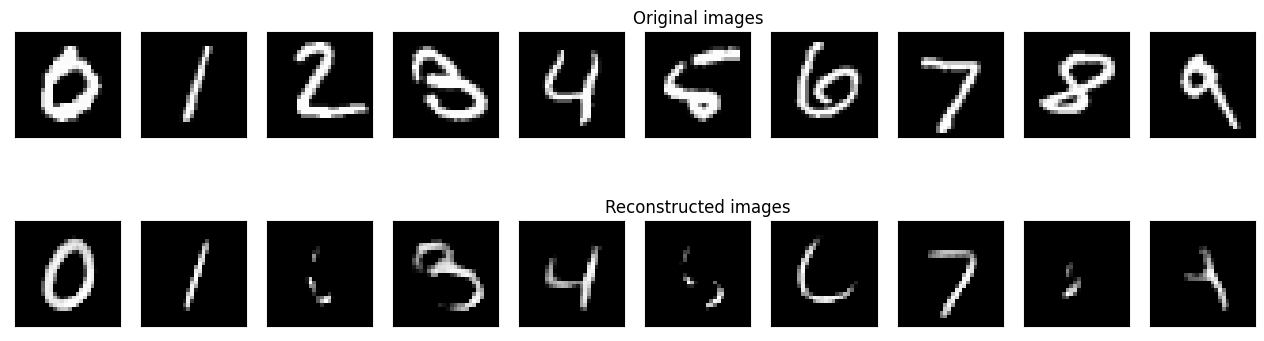


 EPOCH 11/50 	 train loss 0.219548761844635 	 val loss 0.21926060318946838


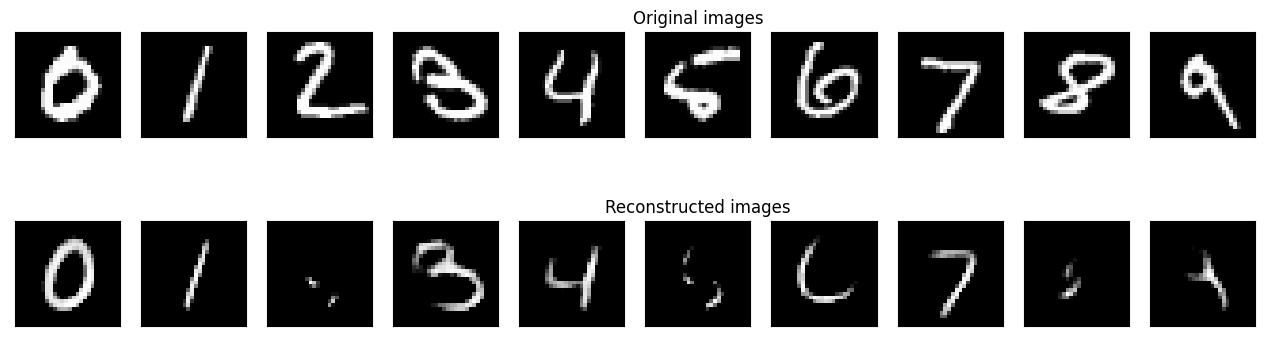


 EPOCH 12/50 	 train loss 0.21954481303691864 	 val loss 0.21922296285629272


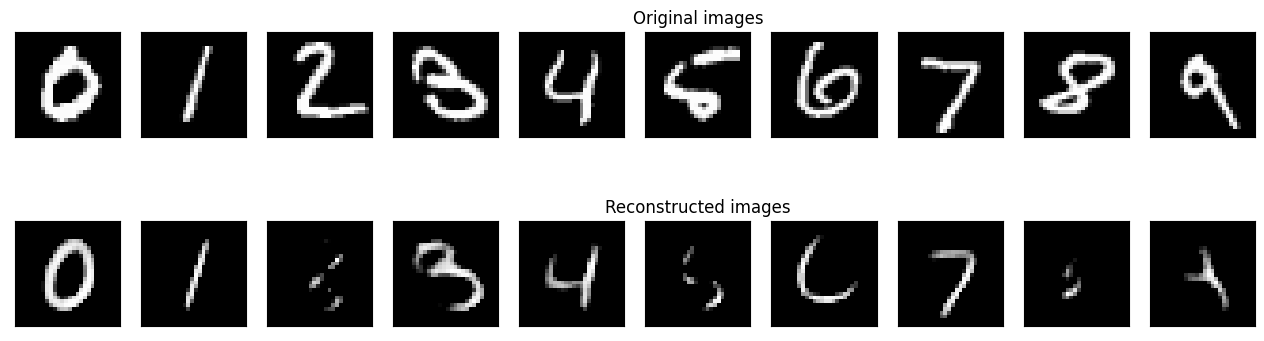


 EPOCH 13/50 	 train loss 0.21953372657299042 	 val loss 0.2192479968070984


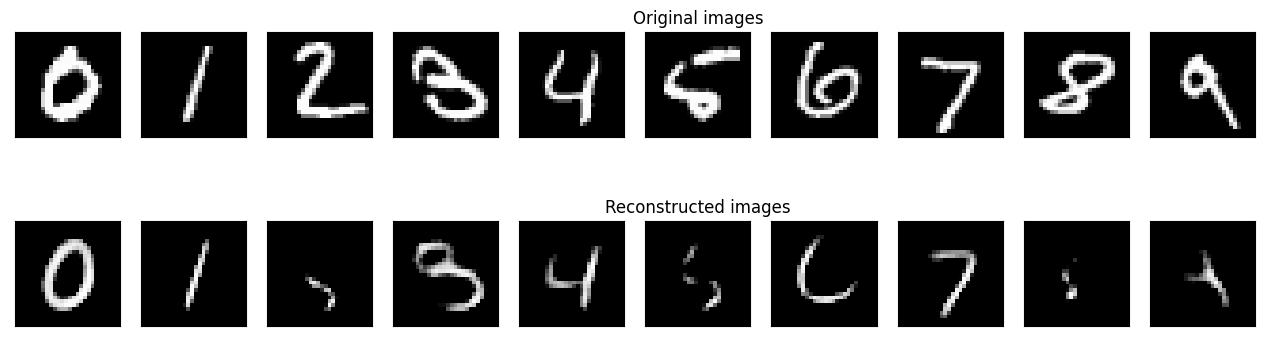


 EPOCH 14/50 	 train loss 0.21951745450496674 	 val loss 0.21919675171375275


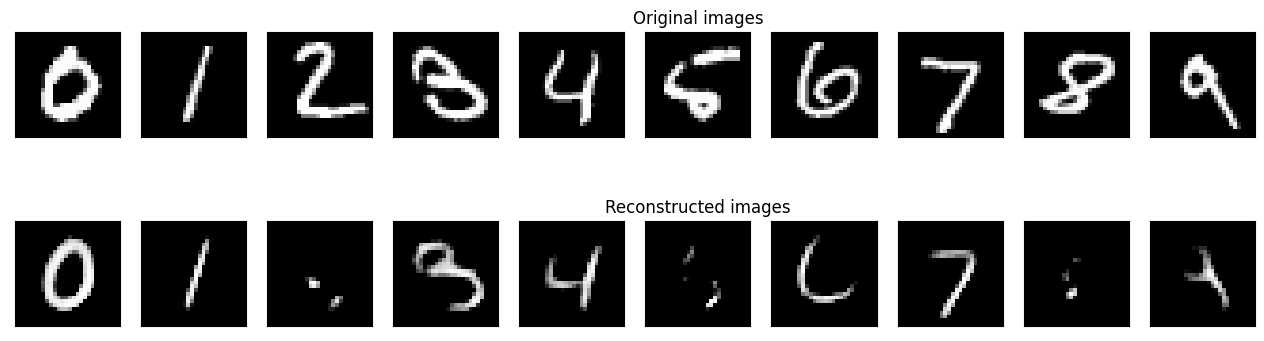


 EPOCH 15/50 	 train loss 0.21950647234916687 	 val loss 0.21924257278442383


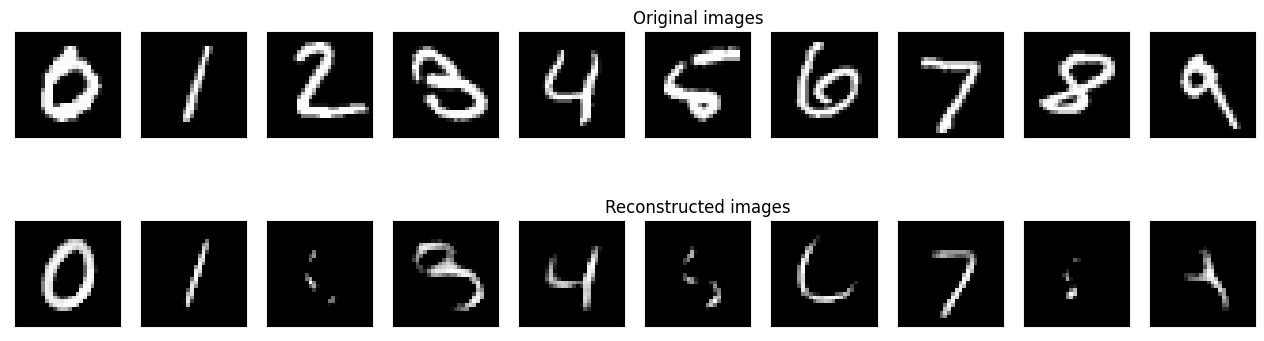


 EPOCH 16/50 	 train loss 0.21950000524520874 	 val loss 0.21920715272426605


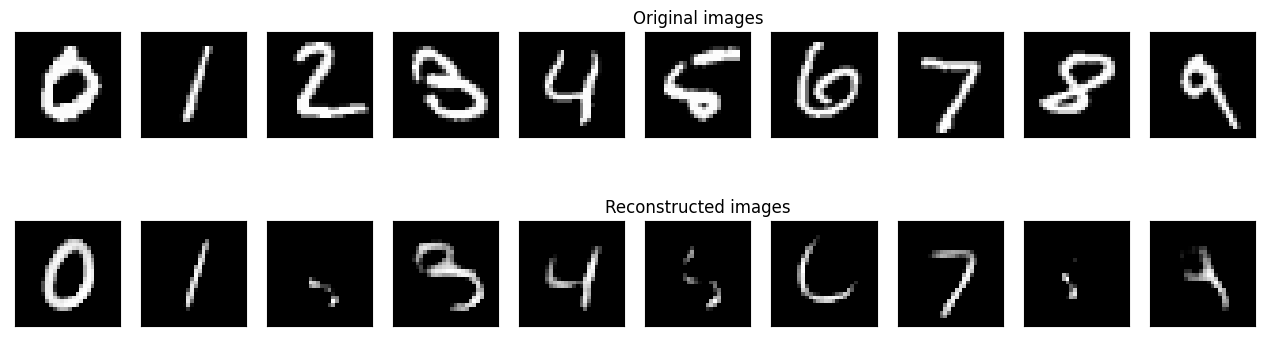


 EPOCH 17/50 	 train loss 0.21950064599514008 	 val loss 0.21915696561336517


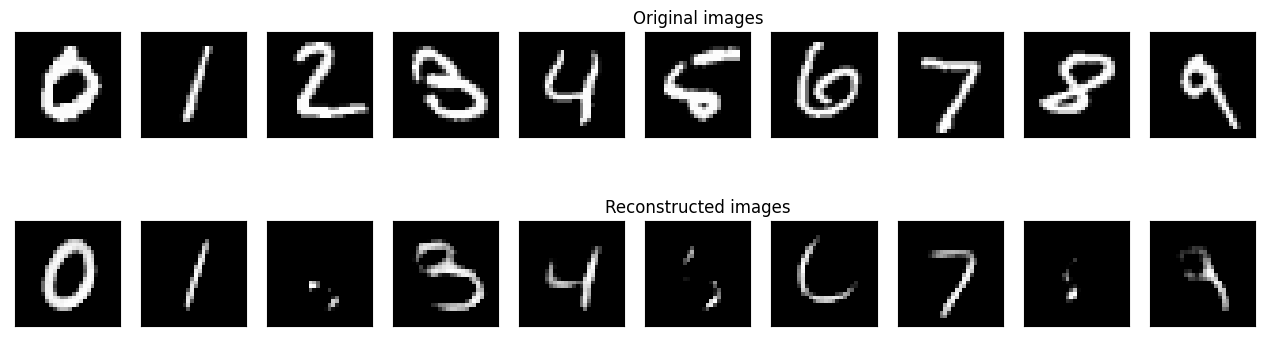


 EPOCH 18/50 	 train loss 0.21947887539863586 	 val loss 0.21917861700057983


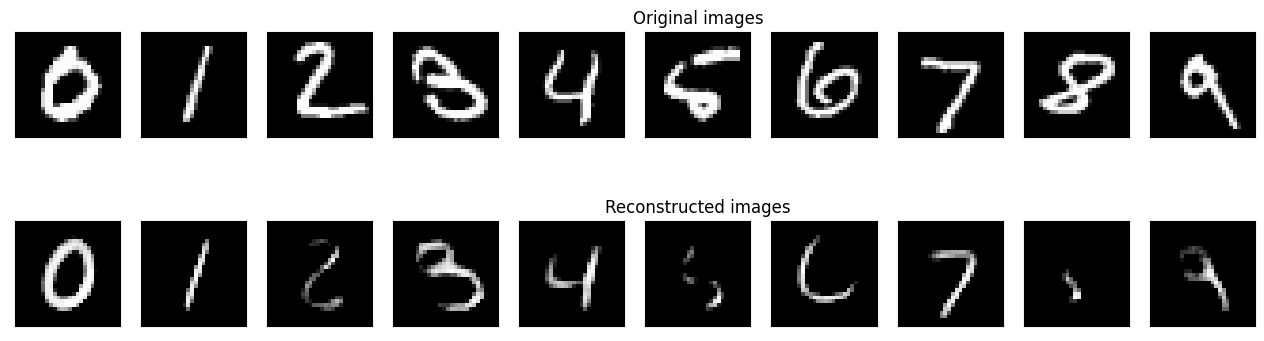


 EPOCH 19/50 	 train loss 0.2194703370332718 	 val loss 0.21916957199573517


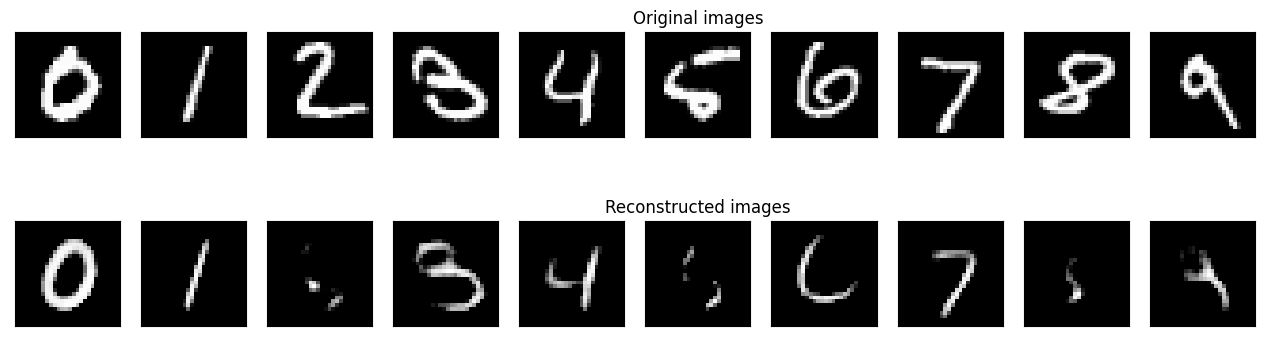


 EPOCH 20/50 	 train loss 0.21946723759174347 	 val loss 0.2192026525735855


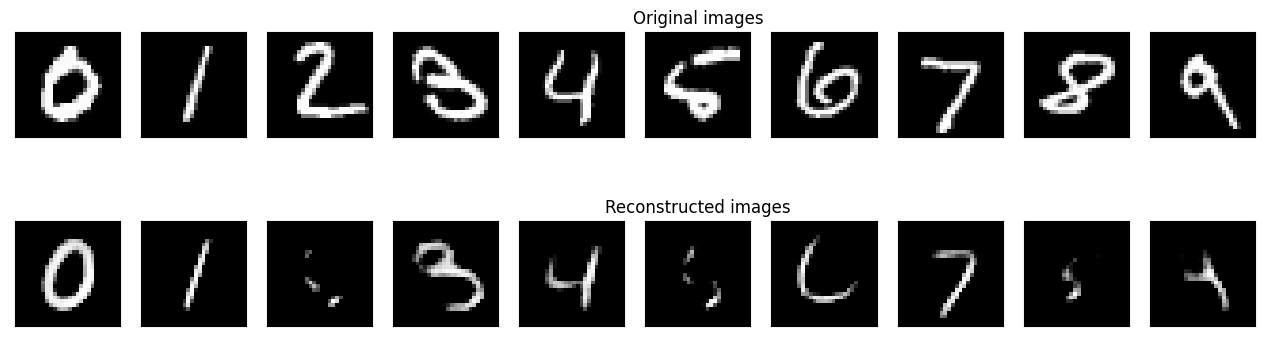


 EPOCH 21/50 	 train loss 0.21946921944618225 	 val loss 0.21921192109584808


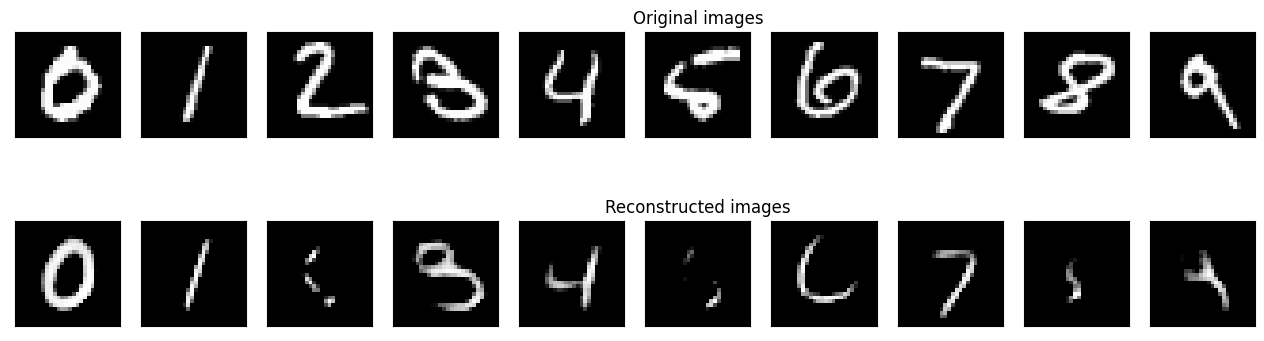


 EPOCH 22/50 	 train loss 0.21945957839488983 	 val loss 0.21918198466300964


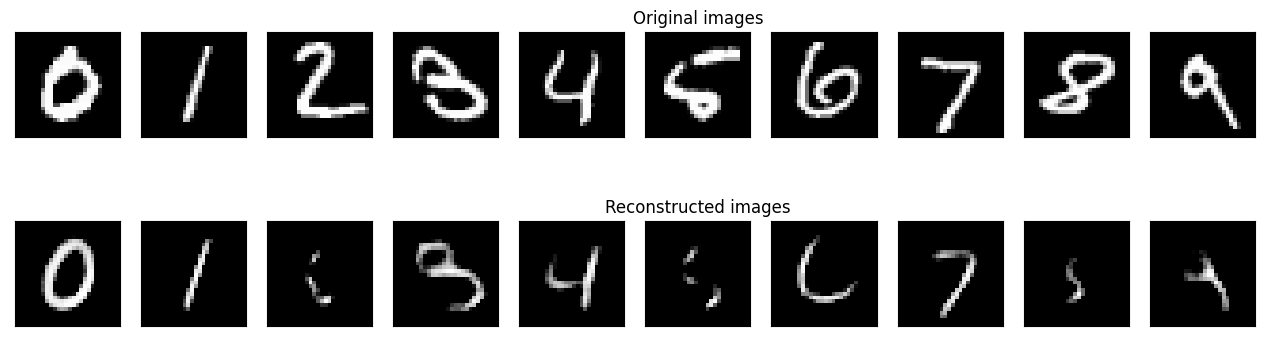


 EPOCH 23/50 	 train loss 0.21943503618240356 	 val loss 0.21921370923519135


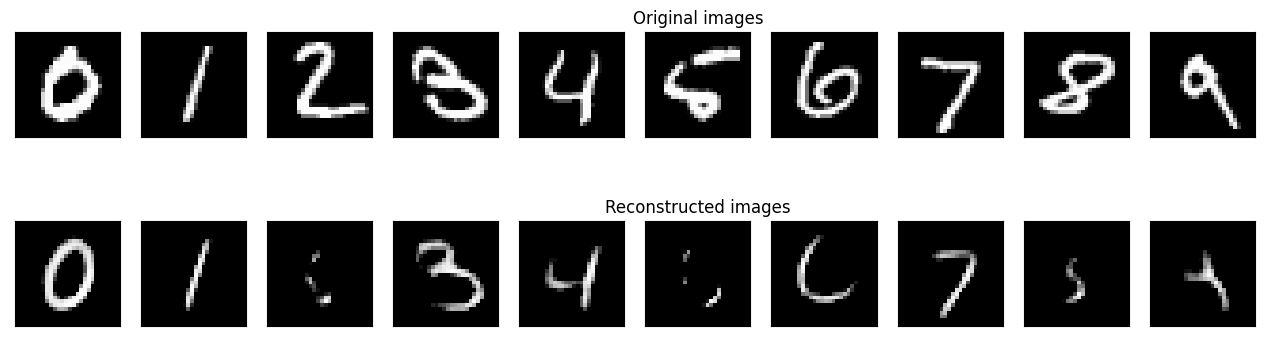


 EPOCH 24/50 	 train loss 0.21943224966526031 	 val loss 0.21917828917503357


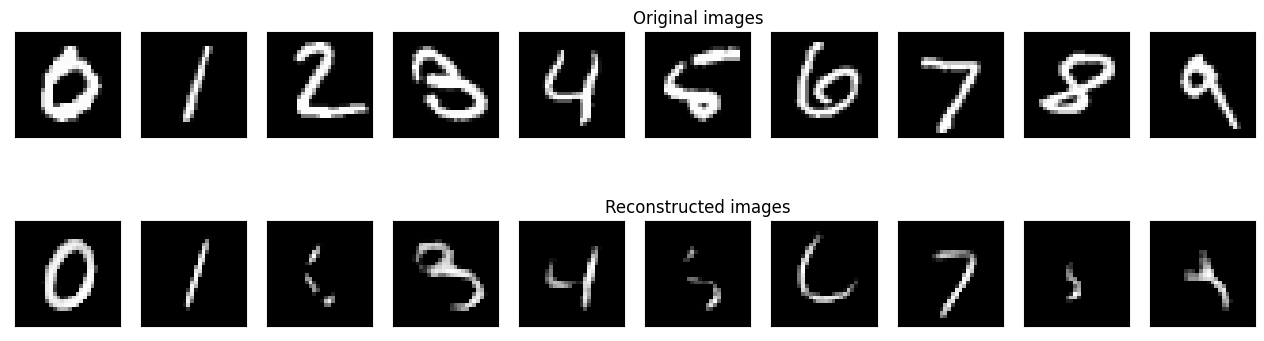


 EPOCH 25/50 	 train loss 0.21941959857940674 	 val loss 0.21911732852458954


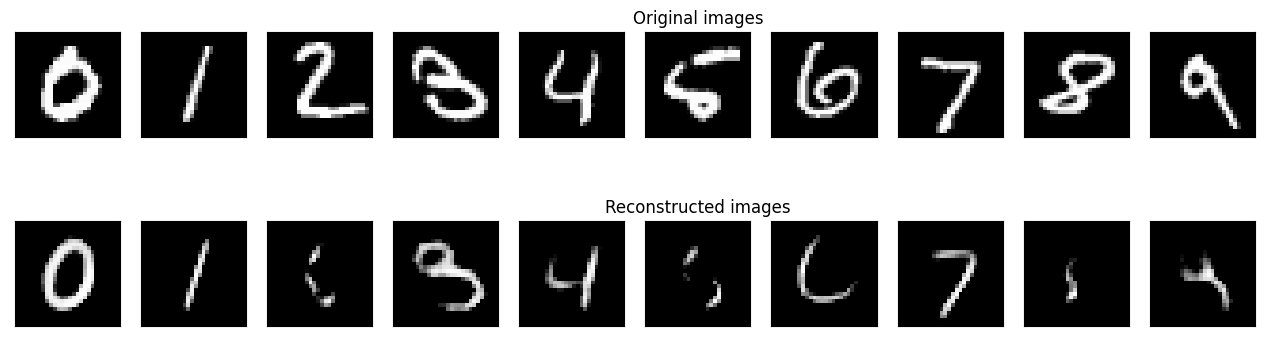


 EPOCH 26/50 	 train loss 0.2194049060344696 	 val loss 0.21914108097553253


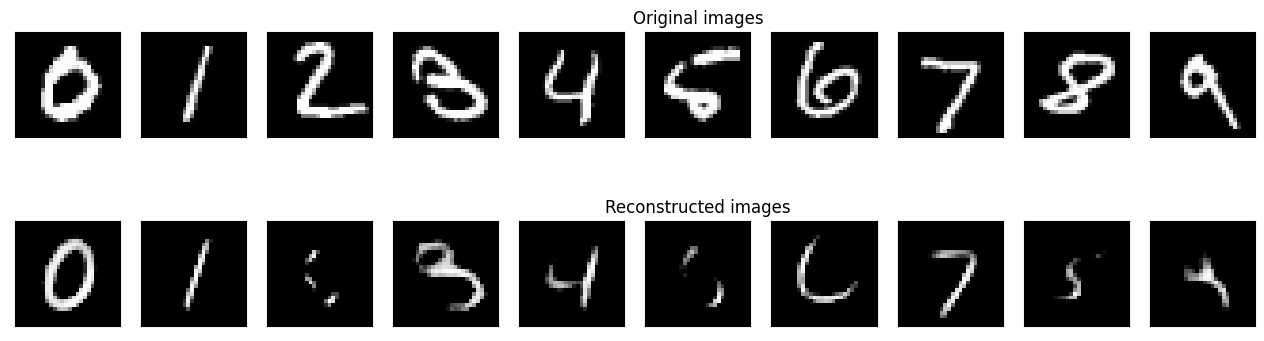


 EPOCH 27/50 	 train loss 0.21940045058727264 	 val loss 0.21914705634117126


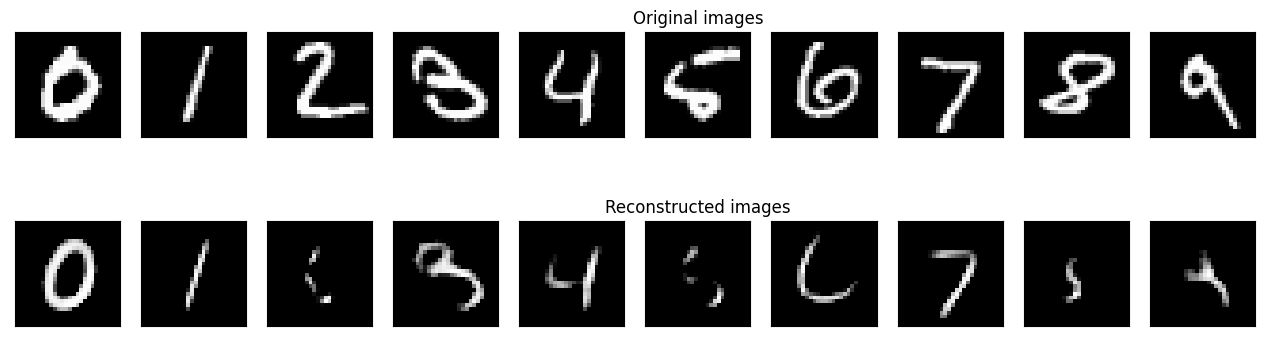


 EPOCH 28/50 	 train loss 0.21939562261104584 	 val loss 0.21911653876304626


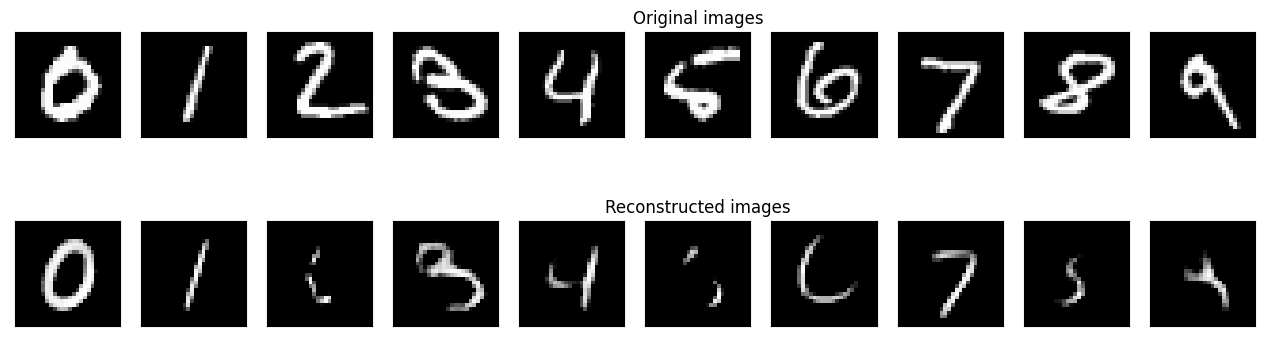


 EPOCH 29/50 	 train loss 0.21938279271125793 	 val loss 0.21911084651947021


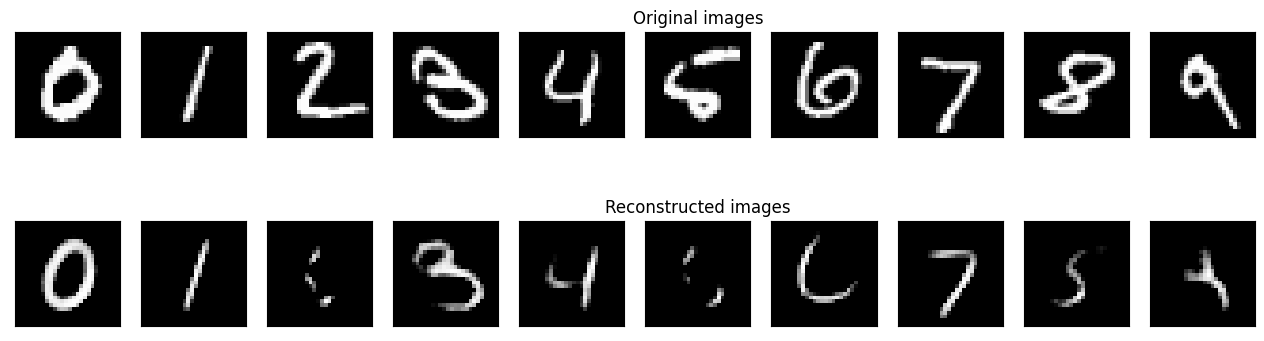


 EPOCH 30/50 	 train loss 0.21938489377498627 	 val loss 0.21914266049861908


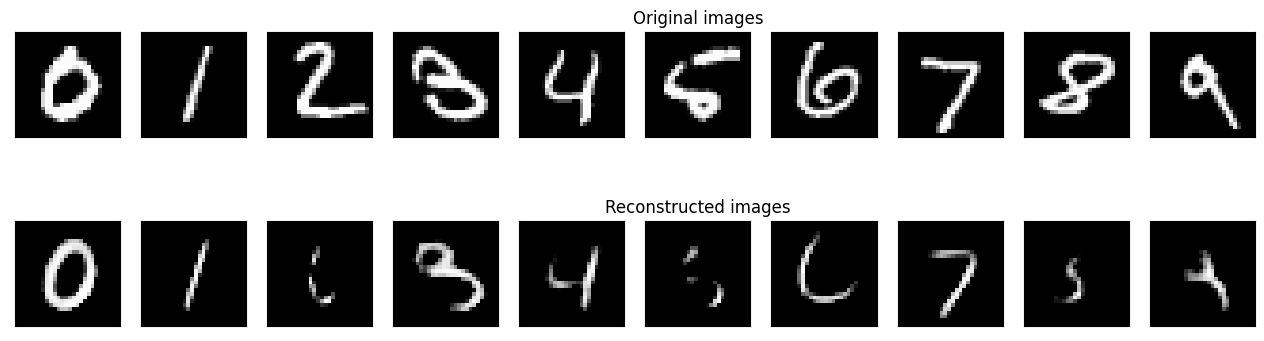


 EPOCH 31/50 	 train loss 0.21936869621276855 	 val loss 0.21912610530853271


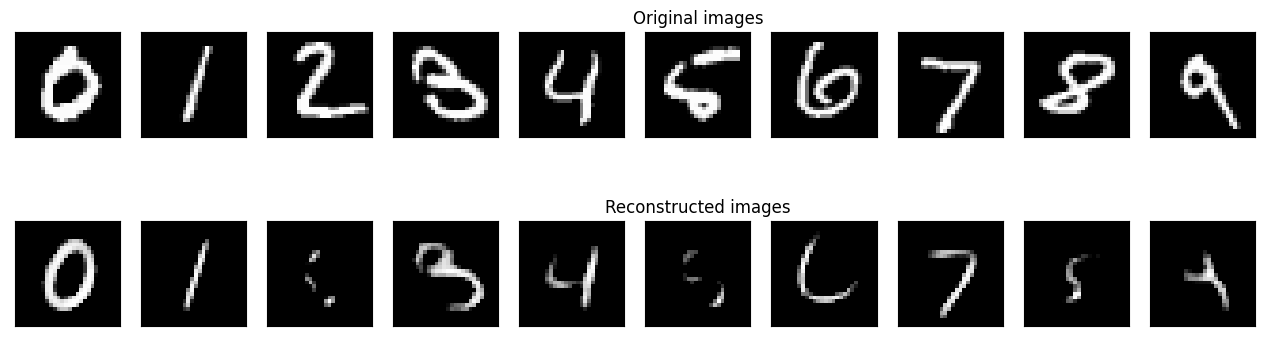


 EPOCH 32/50 	 train loss 0.21936312317848206 	 val loss 0.21910317242145538


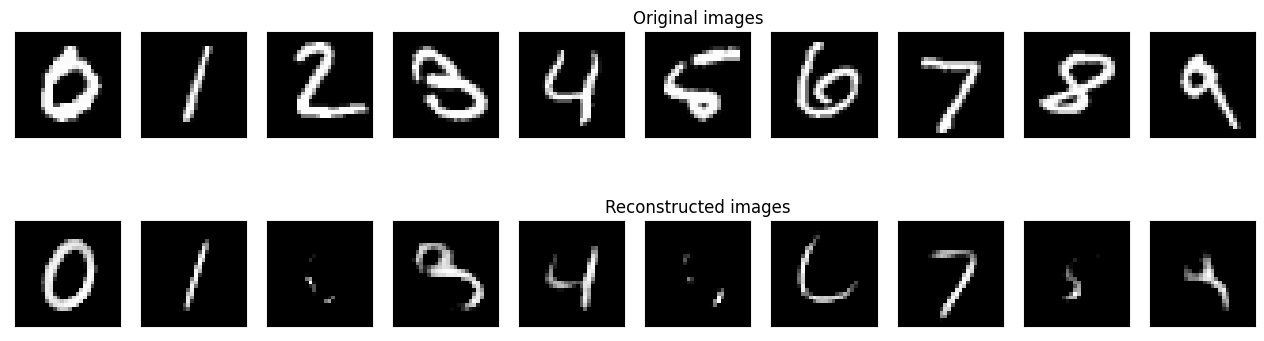


 EPOCH 33/50 	 train loss 0.21935750544071198 	 val loss 0.21917763352394104


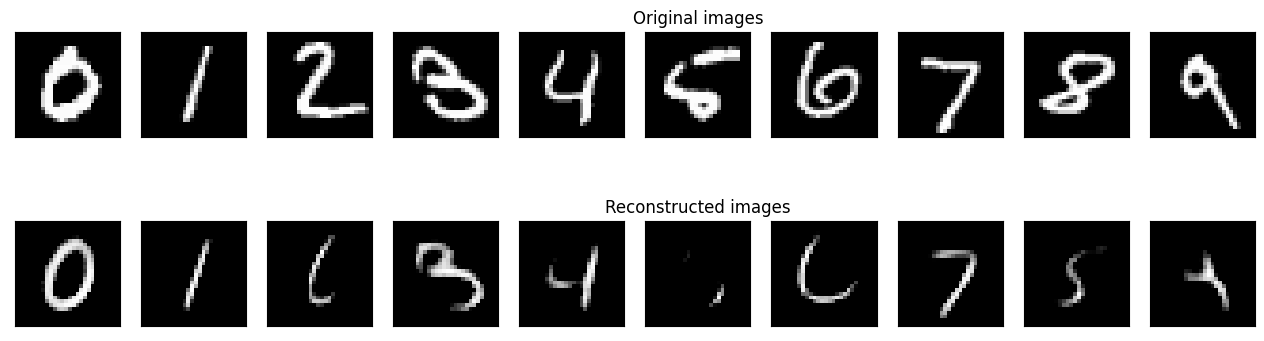


 EPOCH 34/50 	 train loss 0.2193545699119568 	 val loss 0.21917614340782166


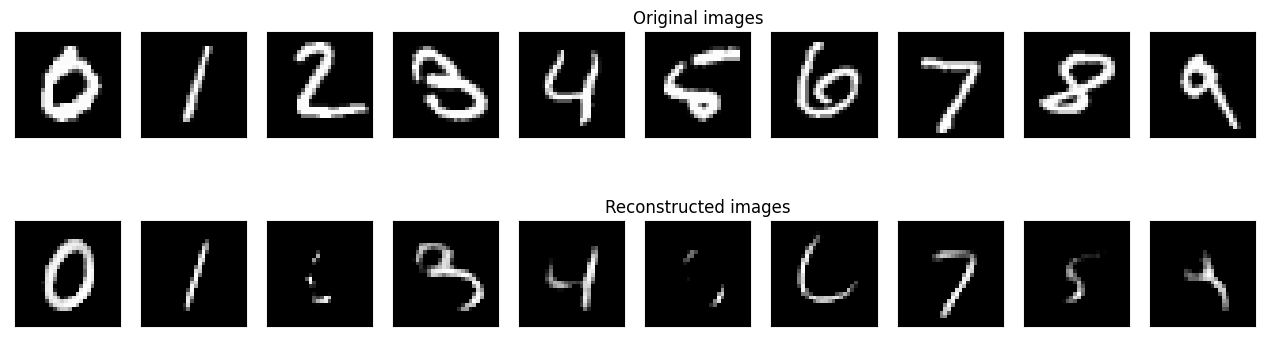

KeyboardInterrupt: 

In [32]:
num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()


0.21940532326698303

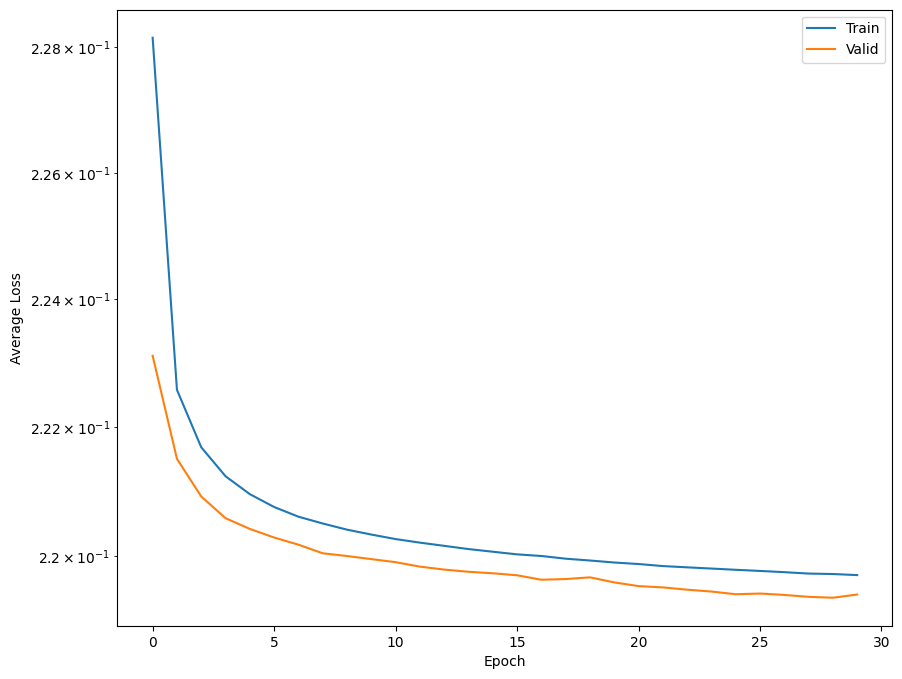

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()